### <span style="color:green">Importing Module</span>

In [234]:
import requests
import time
import datetime
from IPython.display import display
import json
import pandas as pd
import numpy as np
import math
import os
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns

### <span style="color:green">Initializing Data</span>

#### Defining Data Functions

In [235]:
def writeJSON(filepath, data):
    with open(filepath, "w") as f:
        f.write(data)
def read_json(filePath):
    with open(filePath) as f:
        data = json.load(f)
    if type(data)==list:
        return pd.DataFrame(data)
    else: return data
def getSum(n):
    sum = 0
    if n==-1:
        return -1
    n=int(n)
    for digit in str(n): 
      sum += int(digit)   
    sum=int(sum)
    return sum
def getRange(n):
    if n<0:
        return n
    n=str(int(n))
    if len(n)<4:
        return int(n)
    else:
        return int(n[-5:-2])
def toExcel(path, dataframe):
    dataframe.to_excel(path, index=False)
def Filter(df,name):
    columns_to_drop = ['is_show',"is_queue"]
    if "is_queue" in df:
        df = df.drop(columns=columns_to_drop)
    json_data = df.to_json(orient='records')
    writeJSON(f"filtered/{name}_filter.json", json_data)
    return df

def training(df, name):
    df.sort_values(by='begintime', ascending=True, inplace=True)
    df['timeShortAdd']=df["begintime"].shift(1).fillna(-1).apply(getRange).apply(getSum)
    df['timeAdd']=df["begintime"].shift(1).fillna(-1).apply(getSum)
    df['prePrice']=df["price"].shift(1).fillna(-1)
    df['preunit']=df["unit"].shift(1).fillna(-1).apply(getSum)
    df['priceAdd']=df["price"].shift(1).fillna(-1).apply(getSum)
    df['serialAdd']=df["sn"].shift(1).fillna(-1).apply(getSum)
    df['IDAdd']=df["id"].shift(1).fillna(-1).apply(getSum)
    json_data = df.to_json(orient='records')
    writeJSON(f"trained/{name}_trained.json", json_data)
    return df
def dropDuplicate(df,filePath):
    df=df.drop_duplicates(subset=['begintime'])
    dump=df.to_json(orient='records')
    writeJSON(filePath, dump)
    return df

#### Reading data files

In [236]:
parity=read_json("datasets/parity.json")["games"]
parity=pd.DataFrame(parity)

#### Data Filteration Operations

In [237]:
parityDF=dropDuplicate(parity,"datasets/parity.json")

In [238]:
parityFiltered=Filter(parityDF, "parity")
#parityFiltered=read_json("filtered/parity_filter.json")

In [239]:
parityTrained=training(parityFiltered,"parity")

In [240]:
parityTrained.head()

,id,project_id,date,sn,price,unit,color,begintime,timeShortAdd,timeAdd,prePrice,preunit,priceAdd,serialAdd,IDAdd
0,81042,1,20230815,402,15208,6,red,1692109980,-1,-1,-1.0,-1,-1,-1,-1
1,81087,1,20230815,447,15309,5,"green,violet",1692118080,18,45,15208.0,6,16,6,15
6,81088,1,20230815,448,15335,6,red,1692118260,9,36,15309.0,5,18,15,24
12,81089,1,20230815,449,15344,9,green,1692118440,11,36,15335.0,6,17,16,25
19,81090,1,20230815,450,15370,6,red,1692118620,13,36,15344.0,9,17,17,26


### <span style="color:green">Visualisation Operations</span>

#### Timestamp vs Unit

C:\Users\vinay\AppData\Local\Temp\ipykernel_8608\1367666003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sn']=df['sn'].apply(int)


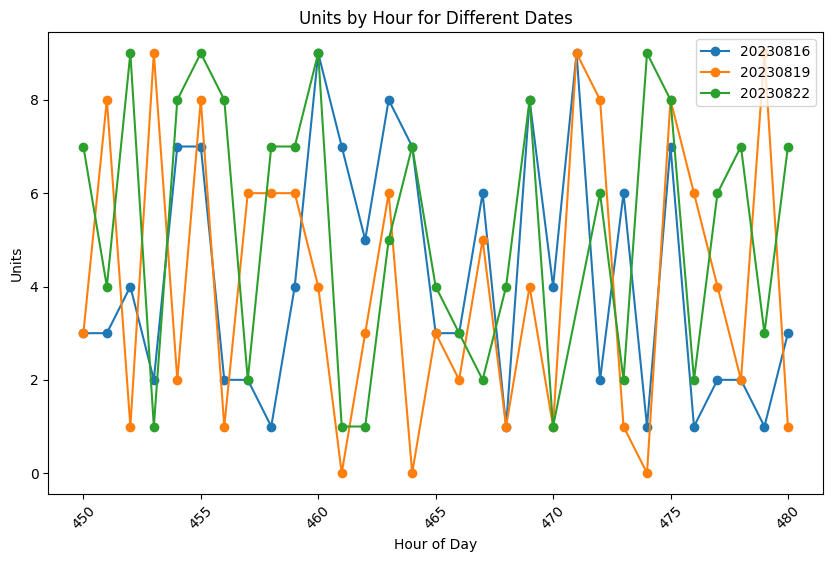

In [16]:
df = parityTrained[['date', 'sn', 'unit']]
# df['hour'] =  pd.to_datetime(df['begintime'], unit='s').dt.hour
# df['minute'] =  pd.to_datetime(df['begintime'], unit='s').dt.minute
unique_dates = df['date'].unique()
plt.figure(figsize=(10, 6))
df['sn']=df['sn'].apply(int)
df = df.sort_values(by='sn')
for date in unique_dates:
    if not (date==20230819 or date==20230816 or date==20230822):
        continue
    data_subset = df[(df['date'] == date) & (df['sn']>=450) &(df['sn']<=480)]
    
    plt.plot(data_subset['sn'], data_subset['unit'], marker='o', linestyle='-', label=str(date))

plt.xlabel('Hour of Day')
plt.ylabel('Units')
plt.title('Units by Hour for Different Dates')
plt.xticks(rotation=45)
# plt.xticks(range(1, 480, 50))
plt.legend()
# plt.grid(True)
plt.show()

#### Price Difference vs Timestamp

C:\Users\vinay\AppData\Local\Temp\ipykernel_8608\432306215.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sn']=df['sn'].apply(int)


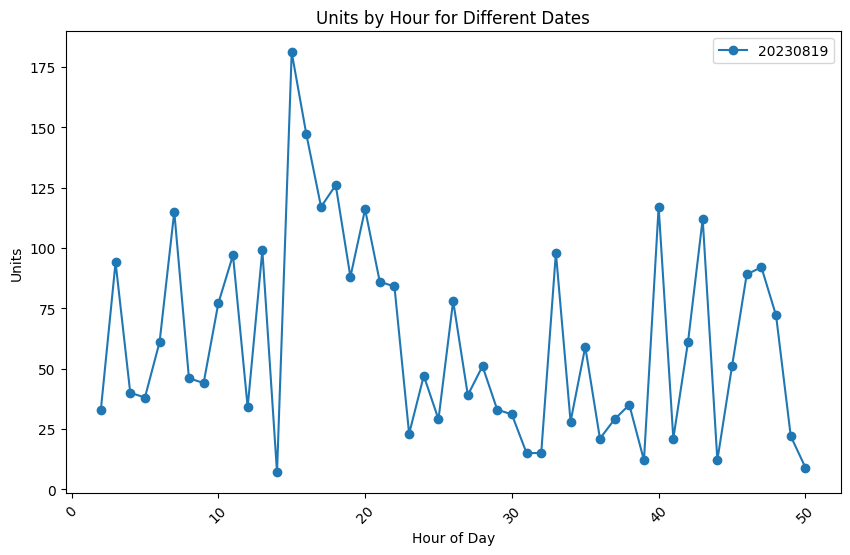

In [46]:
df = parityTrained[['date', 'sn', 'price']]
unique_dates = df['date'].unique()
plt.figure(figsize=(10, 6))
df['sn']=df['sn'].apply(int)
df = df.sort_values(by='sn')
df["prePrice"]=df["price"].shift(1).fillna(0)
df["diff"]=abs(df['price']-df['prePrice'])
for date in unique_dates:
    if not (date==20230819):
        continue
    data_subset = df[(df['date']==date)&(df['sn']>=1) &(df['sn']<=50)]
    
    plt.plot(data_subset['sn'][1:], data_subset['diff'][1:], marker='o', linestyle='-', label=str(date))

plt.xlabel('Hour of Day')
plt.ylabel('Units')
plt.title('Units by Hour for Different Dates')
plt.xticks(rotation=45)
# plt.xticks(range(1, 480, 50))
plt.legend()
# plt.grid(True)
plt.show()

#### Color vs Timestamp

C:\Users\vinay\AppData\Local\Temp\ipykernel_8608\2078801116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["color_map"]=df["color"].map(color_map)
C:\Users\vinay\AppData\Local\Temp\ipykernel_8608\2078801116.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sn']=df['sn'].apply(int)


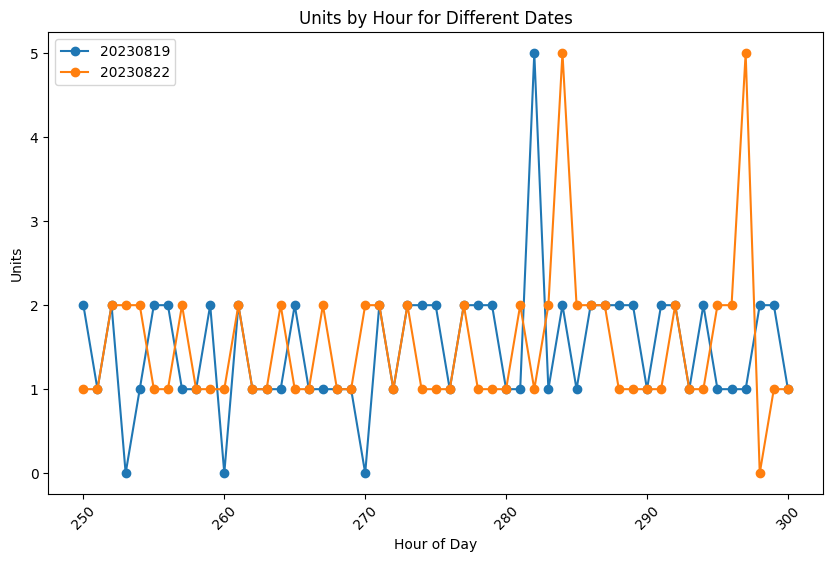

In [47]:
color_map={"red":2, "green":1,"green,violet":5, "red,violet":0}
df = parityTrained[['date', 'sn', 'color']]
df["color_map"]=df["color"].map(color_map)
unique_dates = df['date'].unique()
plt.figure(figsize=(10, 6))
df['sn']=df['sn'].apply(int)
df = df.sort_values(by='sn')
for date in unique_dates:
    if not (date==20230819 or date==20230822):
        continue
    data_subset = df[(df['date'] == date) & (df['sn']>=250) &(df['sn']<=300)]
    
    plt.plot(data_subset['sn'], data_subset['color_map'], marker='o', linestyle='-', label=str(date))

plt.xlabel('Hour of Day')
plt.ylabel('Units')
plt.title('Units by Hour for Different Dates')
plt.xticks(rotation=45)
# plt.xticks(range(1, 480, 50))
plt.legend()
# plt.grid(True)
plt.show()

In [54]:
 ax.scatter?

Object `ax.scatter` not found.


### <span style="color:green">Prediction Operations</span>

#### Data Prepration for LSTM Model

In [62]:
parityFiltered=read_json("filtered/parity_filter.json")
parityFiltered.head()

,id,project_id,date,sn,price,unit,color,begintime
0,81042,1,20230815,402,15208,6,red,1692109980
1,81087,1,20230815,447,15309,5,"green,violet",1692118080
2,81088,1,20230815,448,15335,6,red,1692118260
3,81089,1,20230815,449,15344,9,green,1692118440
4,81090,1,20230815,450,15370,6,red,1692118620


In [71]:
df=parityFiltered[["date","sn","price","unit","color","begintime"]]
df['period']=df['date'].astype(str)+df['sn']
df['period']=df['period'].apply(int)
df['date']=pd.to_datetime(parityFiltered['date'].astype(str),format='%Y%m%d')
df.set_index('date',inplace=True)

C:\Users\vinay\AppData\Local\Temp\ipykernel_8608\3819164288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period']=df['date'].astype(str)+df['sn']
C:\Users\vinay\AppData\Local\Temp\ipykernel_8608\3819164288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period']=df['period'].apply(int)
C:\Users\vinay\AppData\Local\Temp\ipykernel_8608\3819164288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [84]:
df=df.sort_values(by='begintime', ascending=True)[38:]

In [95]:
df['postprice']=df["price"].shift(-1).fillna(-1)
df=df[:-1]

In [155]:
trainingData=df[['price', 'unit','period',"postprice"]]

In [193]:
#Normalizing or scaling dataset
scaler = StandardScaler()
scaler = scaler.fit(trainingData)
training_data_scaled = scaler.transform(trainingData)

In [226]:
training_data_scaled=trainingData
training_data_scaled.shape

In [225]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 3. We will make timesteps = 10 (past days data used for training).

trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 10

for i in range(n_past, len(training_data_scaled) - n_future +1):
    trainX.append(training_data_scaled[i - n_past:i, 0:training_data_scaled.shape[1]-1])
    trainY.append(training_data_scaled[i - 1:i + n_future-1, 3])

In [195]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [196]:
trainX

array([[[ 0.17002932,  0.76903776, -1.69997537],
        [ 0.20718782,  1.12428855, -1.69955559],
        [ 0.32795293,  0.41378697, -1.6991358 ],
        ...,
        [ 0.07713307, -0.65196541, -1.69703687],
        [ 0.10035713,  0.05853617, -1.69661708],
        [ 0.0121057 ,  1.47953934, -1.69619729]],

       [[ 0.20718782,  1.12428855, -1.69955559],
        [ 0.32795293,  0.41378697, -1.6991358 ],
        [ 0.202543  ,  0.76903776, -1.69871601],
        ...,
        [ 0.10035713,  0.05853617, -1.69661708],
        [ 0.0121057 ,  1.47953934, -1.69619729],
        [ 0.00746089, -1.36246699, -1.69577751]],

       [[ 0.32795293,  0.41378697, -1.6991358 ],
        [ 0.202543  ,  0.76903776, -1.69871601],
        [ 0.07713307,  0.76903776, -1.69829623],
        ...,
        [ 0.0121057 ,  1.47953934, -1.69619729],
        [ 0.00746089, -1.36246699, -1.69577751],
        [-0.12723866,  1.47953934, -1.69535772]],

       ...,

       [[ 2.81292747, -1.36246699,  1.72296554],
        [ 2

In [197]:
trainY

array([[ 0.00673475],
       [-0.12781687],
       [-0.19277282],
       ...,
       [ 2.98542913],
       [ 2.85551723],
       [ 2.94367173]])

In [198]:
print(training_data_scaled[12])
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

[-0.19226603 -0.29671462 -1.69493793 -0.09069918]
trainX shape == (3777, 10, 3).
trainY shape == (3777, 1).


In [199]:
# Defining the Auto Encoder Model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 64)            17408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29857 (116.63 KB)
Trainable params: 29857 (116.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [205]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Epoch 1/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0429 - val_loss: 0.1908
Epoch 2/1000
213/213 [==============================] - 3s 15ms/step - loss: 0.0411 - val_loss: 0.0817
Epoch 3/1000
213/213 [==============================] - 3s 15ms/step - loss: 0.0416 - val_loss: 0.0179
Epoch 4/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0414 - val_loss: 0.0590
Epoch 5/1000
213/213 [==============================] - 4s 17ms/step - loss: 0.0392 - val_loss: 0.0309
Epoch 6/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0390 - val_loss: 0.0242
Epoch 7/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0361 - val_loss: 0.0315
Epoch 8/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0363 - val_loss: 0.0207
Epoch 9/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0378 - val_loss: 0.0558
Epoch 10/1000
213/213 [==============================] - 3s 16ms/step - l

Epoch 80/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0320 - val_loss: 0.0271
Epoch 81/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0308 - val_loss: 0.0251
Epoch 82/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0359 - val_loss: 0.0175
Epoch 83/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0328 - val_loss: 0.0244
Epoch 84/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0313 - val_loss: 0.0144
Epoch 85/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0327 - val_loss: 0.0234
Epoch 86/1000
213/213 [==============================] - 4s 17ms/step - loss: 0.0330 - val_loss: 0.0113
Epoch 87/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0330 - val_loss: 0.0164
Epoch 88/1000
213/213 [==============================] - 4s 17ms/step - loss: 0.0318 - val_loss: 0.0100
Epoch 89/1000
213/213 [==============================] - 4s 17ms

213/213 [==============================] - 3s 15ms/step - loss: 0.0234 - val_loss: 0.0220
Epoch 237/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0241 - val_loss: 0.0370
Epoch 238/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0246 - val_loss: 0.0327
Epoch 239/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0237 - val_loss: 0.0247
Epoch 240/1000
213/213 [==============================] - 3s 15ms/step - loss: 0.0230 - val_loss: 0.0343
Epoch 241/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0237 - val_loss: 0.0256
Epoch 242/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0242 - val_loss: 0.0217
Epoch 243/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0244 - val_loss: 0.0244
Epoch 244/1000
213/213 [==============================] - 3s 15ms/step - loss: 0.0224 - val_loss: 0.0277
Epoch 245/1000
213/213 [==============================] - 3s 16ms/step

213/213 [==============================] - 3s 16ms/step - loss: 0.0206 - val_loss: 0.0741
Epoch 393/1000
213/213 [==============================] - 3s 15ms/step - loss: 0.0219 - val_loss: 0.1032
Epoch 394/1000
213/213 [==============================] - 3s 15ms/step - loss: 0.0209 - val_loss: 0.0619
Epoch 395/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0214 - val_loss: 0.0899
Epoch 396/1000
213/213 [==============================] - 3s 15ms/step - loss: 0.0214 - val_loss: 0.0989
Epoch 397/1000
213/213 [==============================] - 4s 17ms/step - loss: 0.0212 - val_loss: 0.0580
Epoch 398/1000
213/213 [==============================] - 3s 16ms/step - loss: 0.0207 - val_loss: 0.0659
Epoch 399/1000
213/213 [==============================] - 4s 17ms/step - loss: 0.0215 - val_loss: 0.0936
Epoch 400/1000
213/213 [==============================] - 3s 15ms/step - loss: 0.0214 - val_loss: 0.0734
Epoch 401/1000
213/213 [==============================] - 3s 16ms/step

In [221]:
# Make Prediction
prediction = model.predict(trainX[-3:-1])

In [222]:
prediction_copies = np.repeat(prediction, trainingData.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [224]:
print(y_pred_future)

In [187]:
trainingData.tail()

,price,unit,period,postprice
date,,,,
2023-08-24,15570,3,20230824443,15553.0
2023-08-24,15553,7,20230824444,15579.0
2023-08-24,15579,6,20230824445,15551.0
2023-08-24,15551,8,20230824446,15570.0
2023-08-24,15570,9,20230824447,15558.0


#### General prediction function

In [36]:
def predictAmanda(date,Round,ID,Unit, price, data,Type, past=0):
    unit=Unit
    element = datetime.datetime.strptime(date,"%d/%m/%Y")
    timestamp = int(datetime.datetime.timestamp(element))
    nextTimeSum=getSum(timestamp+(3*(Round+1)*60))
    timestamp=timestamp+(3*Round*60)
    TSumShort=getSum(getRange(timestamp))
    Tsum=getSum(timestamp)
    Psum=getSum(price)
    Rsum=getSum(Round)
    Isum=getSum(ID)
    Utype=unit%2
    print(f"Timestamp: {timestamp}, Timestamp sum: {Tsum}, Short Time: {TSumShort}, Price sum: {Psum}, Round sum: {Rsum}, Unit: {unit}, \nNext ID: {Isum}")
    #result=data[(data["timeAdd"]==Tsum) & (data["priceAdd"]==Psum) & (data["serialAdd"]==Rsum) &(data["preunit"]%2==Utype)]
    result=data[(data["prePrice"]==price)]
    if Type=="parity":
        result=result[(result["price"]<20000) ]
    display(result[abs(result["price"]-price)<=35])
    grouped_df = result.groupby('color').agg(
                    Count=pd.NamedAgg(column='color', aggfunc='count'),
#                     Mean=pd.NamedAgg(column='Value', aggfunc='mean'),
#                     Sum=pd.NamedAgg(column='Value', aggfunc='sum'),
#                     Max=pd.NamedAgg(column='Value', aggfunc='max'),
#                     Min=pd.NamedAgg(column='Value', aggfunc='min')
    ).reset_index()
    display(grouped_df)
    display(result)
    if past>0:
        for each in result["id"]:
#             unit=(result[result["id"]==each]["unit"])[0]
            unit = result.loc[data[data['id'] == each].index[0], 'unit']
            print(f"\nFor ID: {each}, Unit:{unit}")
            display(data[(data["id"]>=(each-past)) & (data["id"]<=each)])
    roundGrouped=data[data['sn']==str(Round)]
    display(roundGrouped.groupby('color').agg(Count=pd.NamedAgg(column='color', aggfunc='count')).reset_index())
        

#### General Prediction

In [31]:
parityTrained=read_json("trained/parity_trained.json")

In [204]:
date="24/08/2023"
Round=460
price=15570
Unit=6
ID=Round+98377-457
past=7
predictAmanda(date,Round,ID,Unit, price, parityTrained, "parity", past)

Timestamp: 1692898200, Timestamp sum: 45, Short Time: 19, Price sum: 18, Round sum: 10, Unit: 6, 
Next ID: 28


,id,project_id,date,sn,price,unit,color,begintime,timeShortAdd,timeAdd,prePrice,preunit,priceAdd,serialAdd,IDAdd
3821,98364,1,20230824,444,15553,7,green,1692895140,22,54,15570.0,3,18,11,29
3825,98368,1,20230824,448,15558,2,red,1692895860,20,54,15570.0,9,18,15,33


,color,Count
0,green,1
1,red,1


,id,project_id,date,sn,price,unit,color,begintime,timeShortAdd,timeAdd,prePrice,preunit,priceAdd,serialAdd,IDAdd
3821,98364,1,20230824,444,15553,7,green,1692895140,22,54,15570.0,3,18,11,29
3825,98368,1,20230824,448,15558,2,red,1692895860,20,54,15570.0,9,18,15,33



For ID: 98364, Unit:7


,id,project_id,date,sn,price,unit,color,begintime,timeShortAdd,timeAdd,prePrice,preunit,priceAdd,serialAdd,IDAdd
3814,98357,1,20230824,437,15555,2,red,1692893880,19,45,15567.0,6,24,13,31
3815,98358,1,20230824,438,15544,1,green,1692894060,20,54,15555.0,2,21,14,32
3816,98359,1,20230824,439,15515,9,green,1692894240,13,45,15544.0,1,19,15,33
3817,98360,1,20230824,440,15532,7,green,1692894420,15,45,15515.0,9,17,16,34
3818,98361,1,20230824,441,15531,1,green,1692894600,17,45,15532.0,7,16,8,26
3819,98362,1,20230824,442,15557,6,red,1692894780,19,45,15531.0,1,15,9,27
3820,98363,1,20230824,443,15570,3,green,1692894960,20,54,15557.0,6,23,10,28
3821,98364,1,20230824,444,15553,7,green,1692895140,22,54,15570.0,3,18,11,29



For ID: 98368, Unit:2


,id,project_id,date,sn,price,unit,color,begintime,timeShortAdd,timeAdd,prePrice,preunit,priceAdd,serialAdd,IDAdd
3818,98361,1,20230824,441,15531,1,green,1692894600,17,45,15532.0,7,16,8,26
3819,98362,1,20230824,442,15557,6,red,1692894780,19,45,15531.0,1,15,9,27
3820,98363,1,20230824,443,15570,3,green,1692894960,20,54,15557.0,6,23,10,28
3821,98364,1,20230824,444,15553,7,green,1692895140,22,54,15570.0,3,18,11,29
3822,98365,1,20230824,445,15579,6,red,1692895320,15,45,15553.0,7,19,12,30
3823,98366,1,20230824,446,15551,8,red,1692895500,17,45,15579.0,6,27,13,31
3824,98367,1,20230824,447,15570,9,green,1692895680,19,45,15551.0,8,17,14,32
3825,98368,1,20230824,448,15558,2,red,1692895860,20,54,15570.0,9,18,15,33


,color,Count
0,green,5
1,red,4


### <span style="color:green">Test Operations</span>

### Basic Functions

In [83]:
pric=14963
pric=str(pric)
int(pric[-4:-1])


496

In [15]:
parityTrained['sn']=parityTrained['sn'].apply(int)
toExcel("trained/parity_trained.xlsx", parityTrained)

### Pattern Test

In [274]:
df=parityTrained[['date','sn', 'price']]
df['sn']=df['sn'].apply(int)
df = df.sort_values(by='sn')
df["prePrice"]=df["price"].shift(1).fillna(0)
df["diff"]=df['price']-df['prePrice']
df.head()

C:\Users\vinay\AppData\Local\Temp\ipykernel_17272\3314039094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sn']=df['sn'].apply(int)


,date,sn,price,prePrice,diff
2157,20230821,1,15028,0.0,15028.0
238,20230817,1,15003,15028.0,-25.0
1197,20230819,1,14972,15003.0,-31.0
1677,20230820,1,14983,14972.0,11.0
717,20230818,1,14990,14983.0,7.0


In [275]:
df[df['date']==20230821].head()

,date,sn,price,prePrice,diff
2157,20230821,1,15028,0.0,15028.0
2158,20230821,2,15041,14986.0,55.0
2159,20230821,3,15040,14965.0,75.0
2160,20230821,4,15054,15004.0,50.0
2161,20230821,5,15055,15035.0,20.0


In [261]:
df[df['date']==20230818]

,date,sn,price,prePrice,diff
717,20230818,1,14990,14983.0,7.0
718,20230818,2,14985,14990.0,-5.0
719,20230818,3,15004,15040.0,-36.0
720,20230818,4,15026,15034.0,-8.0
721,20230818,5,15024,15022.0,2.0
...,...,...,...,...,...
1192,20230818,476,14738,14527.0,211.0
1193,20230818,477,14745,14870.0,-125.0
1194,20230818,478,14752,14888.0,-136.0
1195,20230818,479,14769,15270.0,-501.0
